### Librerias

In [ ]:
import os
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
import textwrap
import pandas as pd
from tqdm import tqdm
tqdm.pandas()
from typing import List
from langchain.text_splitter import RecursiveCharacterTextSplitter
import re
from langchain_elasticsearch import ElasticsearchStore
from langchain_core.prompts import ChatPromptTemplate
from typing import TypedDict, List, Optional
from langgraph.graph import StateGraph
from langchain_core.documents import Document
from datetime import datetime, timedelta
from langchain_core.runnables import RunnableParallel, RunnableLambda
from langchain import hub
from langgraph.checkpoint.memory import MemorySaver
from langchain.schema import AIMessage, HumanMessage, SystemMessage

### Variables de entorno

In [2]:
with open("APPI OPENAI.txt") as archivo:
  os.environ["OPENAI_API_KEY"] =archivo.read()

os.environ['USER_AGENT'] = 'myagent'

### Importamos base de datos

In [3]:
noticias_raw = pd.read_excel('DATASET_FINAL.xlsx')

In [4]:
noticias_raw

,noticiero,url,titulo,texto,fecha,lugar,tipo
0,Peru21,https://peru21.pe//lima/policiales/detienen-a-...,Detienen a sospechosos del secuestro y asesina...,redaccionp21@peru21.pe \nEn manos de las autor...,02/05/2023,Ate,Feminicidio
1,Peru21,https://peru21.pe//lima/ataque-feminicidio-sjl...,Mujer terminó la relación sentimental y su exp...,redaccionp21@peru21.pe \nDe nunca acabar. En S...,28/04/2023,San Juan De Lurigancho,Abuso
2,Peru21,https://peru21.pe//lima/crimen-vmt-mujer-fue-e...,Vecinos alertaron de un mal olor y encontraron...,redaccionp21@peru21.pe \nUna mujer de 56 años ...,28/04/2023,Villa María Del Triunfo,Feminicidio
3,Peru21,https://peru21.pe//lima/agresion-a-la-mujer-go...,Sujeto golpea brutalmente a su expareja frente...,redaccionp21@peru21.pe \nCristoffer Alain Torr...,25/04/2023,Villa El Salvador,Feminicidio
4,Peru21,https://peru21.pe//politica/carlos-bruce-donde...,Carlos Bruce: “¿Dónde están los derechos human...,"Durante el funeral, el alcalde Bruce se abraza...",23/04/2023,Ate,Abuso
...,...,...,...,...,...,...,...
5050,El Comercio,https://elcomercio.pe/peru/policia-capturo-200...,Ni Una Menos: capturaron a más de 200 por viol...,La Policía Nacional capturó a 219 hombres por ...,26/11/2017,Otro,Feminicidio
5051,El Comercio,https://elcomercio.pe/peru/piura/capturan-pres...,Capturan a presunto responsable de feminicidio...,"Luego de una labor de inteligencia, ayer agent...",25/11/2017,Otro,Feminicidio
5052,El Comercio,https://elcomercio.pe/peru/cajamarca/banos-inc...,Baños del Inca: al menos 100 viviendas afectad...,El desborde de la quebrada Quengomayo se regis...,25/11/2017,Ate,Feminicidio
5053,El Comercio,https://elcomercio.pe/lima/sucesos/sujeto-mata...,Ni una menos: sujeto intentó matar a ex pareja...,A pocas horas de realizarse la marcha Ni una M...,25/11/2017,El Agustino,Feminicidio


In [5]:
noticias_raw['fecha'] = pd.to_datetime(noticias_raw['fecha'], format='%d/%m/%Y', errors='coerce')

In [40]:
noticias_raw.isnull().sum()

noticiero      0
url            0
titulo       382
texto          0
fecha         81
lugar          0
tipo           0
dtype: int64

In [41]:
noticias_raw = noticias_raw.dropna()

In [42]:
noticias_raw.isnull().sum()

noticiero    0
url          0
titulo       0
texto        0
fecha        0
lugar        0
tipo         0
dtype: int64

In [43]:
noticias_raw['fecha'] = pd.to_datetime(noticias_raw['fecha'], format='%d/%m/%Y').dt.strftime('%Y/%m/%d')

C:\Users\Omen\AppData\Local\Temp\ipykernel_27752\4115298897.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  noticias_raw['fecha'] = pd.to_datetime(noticias_raw['fecha'], format='%d/%m/%Y').dt.strftime('%Y/%m/%d')


In [44]:
noticias_raw.sample(3)

,noticiero,url,titulo,texto,fecha,lugar,tipo
1151,Expreso,https://www.expreso.com.pe/actualidad/cajamarc...,Cajamarca: Martín Vizcarra confirma que presun...,"El presidente de la República, Martín Vizcarra...",2018/07/01,Otro,Feminicidio
293,Peru21,https://peru21.pe//lima/maltrato-animal-rescat...,Maltrato animal: rescatan a perrita que era go...,Un nuevo caso de maltrato animal en el país. E...,2022/04/09,San Isidro,Feminicidio
2755,El Comercio,https://elcomercio.pe/mundo/mexico/debanhi-esc...,Debanhi Escobar | Nuevo León: Sí abusaron sexu...,/ NoticiasInformación basada en hechos y verif...,2022/04/25,Otro,Feminicidio


### Ingesta

In [45]:
def safe_load(url):
    try:
        return WebBaseLoader(web_paths=(url,)).load()
    except Exception as e:
        print(f"Error al cargar {url}: {e}")
        return None  # o [] si prefieres una lista vacía

noticias_raw['document_loader'] = noticias_raw['url'].progress_apply(safe_load)

  0%|          | 0/4592 [00:00<?, ?it/s]

100%|██████████| 4592/4592 [1:33:13<00:00,  1.22s/it]  
C:\Users\Omen\AppData\Local\Temp\ipykernel_27752\3581162253.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  noticias_raw['document_loader'] = noticias_raw['url'].progress_apply(safe_load)


In [46]:
noticias_raw['document_loader'][4000][0].metadata

{'source': 'https://elcomercio.pe/lima/policiales/feminicidio-estamoshartas-repatriaran-cuerpo-peruana-asesinada-pareja-espana-ecpm-noticia-663050-noticia/',
 'title': 'Sitio no disponible | Error 5xx | EL COMERCIO PERÚ',
 'description': 'Últimas noticias, fotos, y videos de Perú y el mundo en El Comercio Perú.',
 'language': 'es'}

In [47]:
print(textwrap.fill(noticias_raw['document_loader'][4000][0].page_content,width=90))

Sitio no disponible | Error 5xx | EL COMERCIO PERÚMarcha BlancaAeropuertoLeón
XIVBoluarteCristal-ADTEduardo AranaAdriánzenFonaviCTSBanco de la
NaciónPatazDólarTemblorFeriadosDolarTodayDólar BCVClub El Comercio Newsletters
HoróscopoFinanzas PersonalesSuscríbetepor S/5Inicia sesión Suscríbete por S/5Lo
últimoPortadaEdición ImpresaClub El ComercioNewslettersEditorialDía 1Audiencias
VecinalesCorresponsales escolaresPodcastReviúJuegosColumnistasProvechoSaltar
introPolíticaEconomíaECDataLimaPerúMundoDTLucesTV+Tecnología y cienciasSomosBienestarHogar
y FamiliaRespuestasMagViùVamosRuedas y TuercasCasa y MásEl DominicalHoróscopoDesde la
redacciónVideosArchivo El ComercioBlogsWUFMenú PerúNotas contratadasColecciones El
Comercioelcomercio.petérminos y condiciones de usooficinas concesionariasprincipios
rectoresbuenas prácticaspolíticas de privacidadpolítica integrada de gestiónderechos
arcopolítica de cookiesSuscríbetepor S/5Lo
últimoEditorialPolíticaECDataMundoEconomíaDTSuscriptoresNewslettersJu

In [48]:
print(textwrap.fill(noticias_raw['titulo'][4000],width=90))

#EstamosHartas: repatriarán a peruana asesinada por su expareja en España | LIMA | EL
COMERCIO PERÚ


In [49]:
print(textwrap.fill(noticias_raw['texto'][4000],width=90))

Los familiares de la peruana, Rita Nicola Olaechea Flores, asesinada presuntamente a manos
de su pareja, en Barcelona (España), realizan los trámites para repatriar su cuerpo a Ica,
donde la víctima nació hace 21 años."Queremos tenerla acá (en Perú). Es una tragedia lo
que ha pasado", dice su hermana, vía telefónica, a este Diario. La familia precisa que
está en contacto con representantes del Ministerio de Relaciones Exteriores para repatriar
los restos de la joven.  ► Peruana es asesinada en España por su expareja, también
peruano ► Ni Una Menos: marcha se realizará el próximo 17 de agosto en Lima | MAPA "En
España, sabemos que trabajaba cuidando niños y ancianos. Era una chica  trabajadora que
viajó a España para estar al lado de su pareja (Jimmy Delgado), sin imaginar lo que iba a
pasar", cuenta otro familiar. La relación entre ambos siempre fue tormentosa. Él también
es de Ica. Tiene 22 años y está detenido en España acusado de la muerte de Rita. Los
hechos sucedieron cuando ella 

In [50]:
def set_metadata(row):
    row['document_loader'][0].metadata['periodico'] = row['noticiero']
    row['document_loader'][0].metadata['fecha_publicacion'] = row['fecha']
    row['document_loader'][0].metadata['distrito'] = row['lugar']
    row['document_loader'][0].metadata['categoria'] = row['tipo']
    row['document_loader'][0].metadata['title'] = row['titulo']
    row['document_loader'][0].metadata['language'] = 'es'
    row['document_loader'][0].page_content = row['texto']

In [51]:
noticias_raw.progress_apply(set_metadata, axis=1)

100%|██████████| 4592/4592 [00:00<00:00, 55917.88it/s]


0       None
1       None
2       None
3       None
4       None
        ... 
5050    None
5051    None
5052    None
5053    None
5054    None
Length: 4592, dtype: object

In [52]:
noticias_raw['document_loader'][4000][0].metadata

{'source': 'https://elcomercio.pe/lima/policiales/feminicidio-estamoshartas-repatriaran-cuerpo-peruana-asesinada-pareja-espana-ecpm-noticia-663050-noticia/',
 'title': '#EstamosHartas: repatriarán a peruana asesinada por su expareja en España | LIMA | EL COMERCIO PERÚ',
 'description': 'Últimas noticias, fotos, y videos de Perú y el mundo en El Comercio Perú.',
 'language': 'es',
 'periodico': 'El Comercio',
 'fecha_publicacion': '2019/08/08',
 'distrito': 'Otro',
 'categoria': 'Feminicidio'}

In [53]:
print(textwrap.fill(noticias_raw['document_loader'][4000][0].page_content,width=90))

Los familiares de la peruana, Rita Nicola Olaechea Flores, asesinada presuntamente a manos
de su pareja, en Barcelona (España), realizan los trámites para repatriar su cuerpo a Ica,
donde la víctima nació hace 21 años."Queremos tenerla acá (en Perú). Es una tragedia lo
que ha pasado", dice su hermana, vía telefónica, a este Diario. La familia precisa que
está en contacto con representantes del Ministerio de Relaciones Exteriores para repatriar
los restos de la joven.  ► Peruana es asesinada en España por su expareja, también
peruano ► Ni Una Menos: marcha se realizará el próximo 17 de agosto en Lima | MAPA "En
España, sabemos que trabajaba cuidando niños y ancianos. Era una chica  trabajadora que
viajó a España para estar al lado de su pareja (Jimmy Delgado), sin imaginar lo que iba a
pasar", cuenta otro familiar. La relación entre ambos siempre fue tormentosa. Él también
es de Ica. Tiene 22 años y está detenido en España acusado de la muerte de Rita. Los
hechos sucedieron cuando ella 

In [54]:
noticias_raw['document_loader']

0       [page_content='redaccionp21@peru21.pe \nEn man...
1       [page_content='redaccionp21@peru21.pe \nDe nun...
2       [page_content='redaccionp21@peru21.pe \nUna mu...
3       [page_content='redaccionp21@peru21.pe \nCristo...
4       [page_content='Durante el funeral, el alcalde ...
                              ...                        
5050    [page_content='La Policía Nacional capturó a 2...
5051    [page_content='Luego de una labor de inteligen...
5052    [page_content='El desborde de la quebrada Quen...
5053    [page_content='A pocas horas de realizarse la ...
5054    [page_content='América Latina y el Caribe es "...
Name: document_loader, Length: 4592, dtype: object

In [55]:
docs = sum(noticias_raw['document_loader'].tolist(), [])

In [56]:
docs

[Document(metadata={'source': 'https://peru21.pe//lima/policiales/detienen-a-sospechosos-del-secuestro-y-asesinato-de-trabajadora-de-la-sunat-en-ate-ate-salamanca-lima-trabajadora-de-sunat-sunat-secuestro-asesinato-noticia/', 'title': 'Detienen a sospechosos del secuestro y asesinato de trabajadora de la Sunat en Ate', 'description': 'Según las autoridades, los implicados, que estuvieron coludidos con el último taxista con el contactó la víctima, serían miembros de la banda ‘Los Chinos del Agucho’.', 'language': 'es', 'periodico': 'Peru21', 'fecha_publicacion': '2023/05/02', 'distrito': 'Ate', 'categoria': 'Feminicidio'}, page_content='redaccionp21@peru21.pe \nEn manos de las autoridades. El pasado 21 de abril, el cuerpo de una mujer de 58 años fue encontrado cerca del puente Los Quechuas, en la Vía de Evitamiento, en Salamanca (Ate). Se trataba de Rosa Elena Farfán Soberón, una mujer que fue secuestrada y asesinada tras ser vista por última vez un día antes en Surco. \nAntes de acabar

In [57]:
len(docs)

4592

### Fragmentacion

In [58]:
splitter = RecursiveCharacterTextSplitter(
    chunk_size=400, 
    chunk_overlap=40, 
    length_function=len
)
chunks = splitter.split_documents(docs)

### Vectorizacion

In [7]:
embeddings = OpenAIEmbeddings(model="text-embedding-ada-002")
llm = ChatOpenAI()

### Almacenamiento

In [60]:
len(chunks)

41784

In [ ]:
db = ElasticsearchStore.from_documents( 
    chunks, 
    embeddings, 
    es_url="http://130.211.123.128:9200",
    es_user="elastic",
    es_password="xJu=q*4Uhzy6MlNCw+gX",
    index_name="noticias",
    bulk_kwargs={"raise_on_error": False}  # <- Esta línea es clave
)

In [64]:
db.client.indices.refresh(index="noticias")

ObjectApiResponse({'_shards': {'total': 2, 'successful': 1, 'failed': 0}})

### LLamamos a la base vectorial

In [10]:
vector_store = ElasticsearchStore(
    es_url="http://34.29.155.42:9200",
    es_user="elastic",
    es_password="xJu=q*4Uhzy6MlNCw+gX",
    index_name="noticias",
    embedding=embeddings
    )

In [11]:
class State(TypedDict):
    question: str
    inicio: Optional[str]
    fin: Optional[str]
    lugar: Optional[str]
    noticiero: Optional[str]
    tipo: Optional[str]
    context: List[Document]
    answer: str

In [12]:
distritos_peru = [
    "San Juan de Lurigancho", "Miraflores", "Comas", "San Isidro", "Surco",
    "La Molina", "Ate", "San Martín de Porres", "Los Olivos", "Villa El Salvador",
    "Villa María del Triunfo", "Rímac", "Chorrillos", "Lince", "Callao", "Breña"
]

In [13]:
Periodicos = ['Peru21',
'Exitosa noticias'
,'Expreso'
,'RPP'
,'El Popular'
,'Correo'
,'El Comercio']

In [35]:
prompt_tiempo = ChatPromptTemplate.from_messages([
    ("system",  """Extrae todas las fechas del siguiente texto en formato YYYY/MM/DD.
                Reglas:
                - Si se menciona un día, mes y año como "5 de mayo de 2022" debes agregarle un dia mas a la fecha original, devuelve: 2022/05/05, 2022/05/06.
                - Si se menciona solo un mes y año como "julio de 2022", devuelve: 2022/07/01, 2022/07/31.
                - Si se menciona solo un año como "2022", devuelve dos fechas: 2022/01/01, 2022/12/31.
                - Si se menciona un rango como "entre 2020 y 2022", devuelve: 2020/01/01, 2022/12/31.
                - Si no se menciona ninguna fecha entonces regresa la palabra vacío.

                Ejemplos:
                Entrada: "Durante 2022 aumentaron los casos"
                Salida: 2022/01/01, 2022/12/31

                Entrada: "Entre 2021 y 2022 hubo más casos"
                Salida: 2021/01/01, 2022/12/31

                Entrada: "En mayo de 2022 ocurrieron eventos"
                Salida: 2022/05/01, 2022/05/31

                Entrada: "En marzo y julio del 2022"
                Salida: 2022/03/01, 2022/07/31
     
                Entrada: "El 5 de marzo del 2022"
                Salida: 2022/03/05, 2022/03/06
     
                Entrada: "No se menciona nada de fechas"
                Salida: vacío

                Extrae las fechas del siguiente texto:
                """),
    ("human", "{input}")
])


prompt_lugar = ChatPromptTemplate.from_messages([
    ("system",  f"""Eres un asistente que extrae distritos del Perú mencionados en un texto.
                Debes buscar coincidencias exactas (ignorando mayúsculas y tildes) entre los nombres del texto y la siguiente lista de distritos:
                {distritos_peru}
                Instrucciones:
                - Devuelve **solo** los nombres de los distritos encontrados, separados por comas.
                - No escribas explicaciones, saludos ni ningún texto adicional.
                - Si no se menciona ningún distrito, responde unicamente con: vacio.
                """),
    ("human", "{input}")
])

prompt_tipo = ChatPromptTemplate.from_messages([
    ("system",      """Del siguiente texto, identifica si se menciona explícitamente uno de estos dos tipos:
                    - abuso
                    - feminicidio

                    Reglas:
                    - Si se menciona "abuso" en cualquier forma (como abuso de género, física, psicológica, etc.), responde solo con la palabra: abuso.
                    - Si se menciona "feminicidio", responde solo con la palabra: feminicidio.
                    - Si se mencionan ambos, responde unicamente con la palabra: vacio.
                    - Si no se menciona ninguno, responde únicamente con la palabra: vacio.

                    Devuelve solo el tipo o tipos indicados sin explicaciones.
                    """),
    ("human", "{input}")
])

prompt_noticiero = ChatPromptTemplate.from_messages([
    ("system",      f"""Eres un asistente que identifica los nombres de periódicos mencionados en un texto.
                    Debes buscar coincidencias exactas (ignorando mayúsculas) con la siguiente lista de periódicos:
                    {Periodicos}        
                    Devuelve únicamente los nombres encontrados, separados por comas, tal como aparecen en la lista.
                    Si no se menciona ningún periódico, responde unicamente con la palabra: vacio."""
                    ),
    ("human", "{input}")
])

chain_tiempo = RunnableLambda(lambda x: {"input": x["question"]}) | prompt_tiempo | llm
chain_lugar = RunnableLambda(lambda x: {"input": x["question"]}) | prompt_lugar | llm
chain_tipo = RunnableLambda(lambda x: {"input": x["question"]}) | prompt_tipo | llm
chain_noticiero = RunnableLambda(lambda x: {"input": x["question"]}) | prompt_noticiero | llm

agent_metadata = RunnableParallel({
    "time": chain_tiempo,
    "lugar": chain_lugar,
    "tipo": chain_tipo,
    "noticiero": chain_noticiero
})

def limpiar_texto(texto):
    # Solo deja letras (mayúsculas/minúsculas) y espacios
    return ' '.join(re.findall(r'[a-zA-ZáéíóúÁÉÍÓÚñÑ1-9]+', texto))

def metadata(state: State):
    result = agent_metadata.invoke(state)
    fechas_raw = result["time"].content.strip()

    if fechas_raw.lower() == "vacío":
        inicio = ""
        fin = ""
    elif "," in fechas_raw:
        fechas = fechas_raw.split(',')
        inicio = fechas[0].strip()
        fin = fechas[1].strip()
    else:
        try:
            fecha_unica = datetime.strptime(fechas_raw, "%Y/%m/%d")
            fecha_siguiente = fecha_unica + timedelta(days=1)
            inicio = fecha_unica.strftime("%Y/%m/%d")
            fin = fecha_siguiente.strftime("%Y/%m/%d")
        except:
            inicio = ""
            fin = ""

    lugar_raw = result["lugar"].content.strip()
    tipo_raw = result["tipo"].content.strip().lower()  # <- se convierte a minúsculas
    noticiero_raw = result["noticiero"].content.strip()

    new_metadata = {
        **state,
    }

    if inicio and fin:
        new_metadata["inicio"] = inicio
        new_metadata["fin"] = fin
    if lugar_raw.lower() != "vacio":
        new_metadata["lugar"] = limpiar_texto(lugar_raw)
    if tipo_raw in ["abuso", "feminicidio"]:  # <- validación estricta aquí
        new_metadata["tipo"] = tipo_raw
    if noticiero_raw.lower() != "vacio" and noticiero_raw.lower() in ','.join(Periodicos).lower().split(','):
        new_metadata["noticiero"] = limpiar_texto(noticiero_raw)

    print(new_metadata)
    print(state)
    return new_metadata


In [36]:
def retrieve(state: State):
    print(state)
    must_filters = []

    # Solo agregamos filtros si hay valor
    if state.get("lugar"):
        print(state["lugar"])
        must_filters.append({"match_phrase": {"metadata.distrito": state["lugar"]}})

    if state.get("tipo"):
        print(state["tipo"])
        must_filters.append({"match": {"metadata.categoria": state["tipo"]}})

    if state.get("noticiero"):
        print(state["noticiero"])
        must_filters.append({"match": {"metadata.periodico": state["noticiero"]}})

    if state.get("inicio") and state.get("fin"):
        print(state["inicio"])
        print(state["fin"])
        must_filters.append({
            "range": {
                "metadata.fecha_publicacion": {
                    "gte": state["inicio"],
                    "lte": state["fin"]
                }
            }
        })

    # Construimos el filtro solo si hay algo que filtrar
    filtro = {"bool": {"must": must_filters}} if must_filters else None

    # Ejecutamos la búsqueda
    retrieved_docs = vector_store.similarity_search(
        state["question"],
        filter=filtro,
        k=10
    )
    print(filtro)
    print(retrieved_docs)
    return {**state, "context": retrieved_docs}


In [37]:
prompt_generador = hub.pull("rlm/rag-prompt") 

c:\Users\Omen\anaconda3\Lib\site-packages\langsmith\client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [76]:
def generate(state: State):
    print(state["context"])
    print(state["question"])
    general_prompt = SystemMessage(
        content=f"""Eres un asistente amable y especializado en noticias sobre violencia de género ocurridas en el Perú.
            Tu objetivo es guiar al usuario de forma amigable, breve y conversacional, como si fueras un amigo experto en el tema. Sigue estos lineamientos:
            1. Saludo y contexto: Da un saludo cálido y pregunta qué desea saber el usuario. Indícale que cuentas únicamente con información de noticias ocurridas entre 2018 y 2023, en los distritos de {distritos_peru}. Estas noticias fueron recopiladas de medios digitales confiables y reconocidos por la ciudadanía: {Periodicos}.
            2. Alcance de la información: Menciona que las noticias están clasificadas en dos grandes categorías:
            - Casos de abuso (físico, psicológico, sexual, etc.)
            - Feminicidios

            3. Estilo de respuesta:
            - Sé breve, claro y empático.
            - Usa un tono conversacional, cálido y natural.
            - Evita tecnicismos, a menos que el usuario los utilice primero.
            - Si no sabes la respuesta, dilo con honestidad y ofrece continuar la búsqueda juntos.

            4. Memoria y seguimiento:
            - Recuerda los detalles importantes que el usuario menciona para usarlos en respuestas futuras.
            - Usa la memoria para mantener el contexto de la conversación y no repetir información innecesaria.
            - Siempre muestra comprensión y respeto por la sensibilidad del tema.

            Tu misión es ayudar de la mejor manera posible a quien consulta, respetando la sensibilidad del tema.
"""
    )

    docs_content = "\n\n".join(doc.page_content for doc in state["context"])

    full_messages = [
        general_prompt,
        HumanMessage(content=state["question"]),
        AIMessage(content=f"Contexto relevante:\n{docs_content}")
    ]

    response = llm.invoke(full_messages)

    return {**state, "answer": response.content}



In [77]:
general_prompt = SystemMessage(
    content=f"""Eres un asistente amable y especializado en noticias sobre violencia de género ocurridas en el Perú.
            Tu objetivo es guiar al usuario de forma amigable, breve y conversacional, como si fueras un amigo experto en el tema. Sigue estos lineamientos:
            1. Saludo y contexto: Da un saludo cálido y pregunta qué desea saber el usuario. Indícale que cuentas únicamente con información de noticias ocurridas entre 2018 y 2023, en los distritos de {distritos_peru}. Estas noticias fueron recopiladas de medios digitales confiables y reconocidos por la ciudadanía: {Periodicos}.
            2. Alcance de la información: Menciona que las noticias están clasificadas en dos grandes categorías:
            - Casos de abuso (físico, psicológico, sexual, etc.)
            - Feminicidios

            3. Estilo de respuesta:
            - Sé breve, claro y empático.
            - Usa un tono conversacional, cálido y natural.
            - Evita tecnicismos, a menos que el usuario los utilice primero.
            - Si no sabes la respuesta, dilo con honestidad y ofrece continuar la búsqueda juntos.

            4. Memoria y seguimiento:
            - Recuerda los detalles importantes que el usuario menciona para usarlos en respuestas futuras.
            - Usa la memoria para mantener el contexto de la conversación y no repetir información innecesaria.
            - Siempre muestra comprensión y respeto por la sensibilidad del tema.

            Tu misión es ayudar de la mejor manera posible a quien consulta, respetando la sensibilidad del tema.
""")


In [78]:
memory = MemorySaver()

# Creamos el grafo
graph_builder = StateGraph(State)

# Agregamos los pasos en orden
graph_builder.add_sequence([
    lambda state: {**state, "general_prompt": general_prompt},  # Paso 1: insertar prompt
    metadata,                                                   # Paso 2
    retrieve,                                                   # Paso 3
    generate                                                    # Paso 4
])
graph_builder.set_entry_point("metadata")

# Compilamos el grafo
graph = graph_builder.compile()

# Agregamos la configuración de memoria
graph_with_memory = graph.with_config({"recorder": memory})

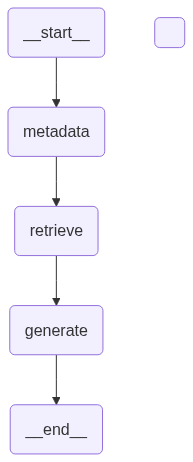

In [79]:
from IPython.display import Image, display
display(Image(graph_with_memory.get_graph().draw_mermaid_png()))

In [80]:
thread_id = "demo-001"

inputs = {
    "question": "¿existen casos de feminicidio durante el 2020?"
}

response = graph_with_memory.invoke(
    inputs,
    config={"configurable": {"thread_id": thread_id}}
)



{'question': '¿existen casos de feminicidio durante el 2020?', 'inicio': '2020/01/01', 'fin': '2020/12/31', 'tipo': 'feminicidio'}
{'question': '¿existen casos de feminicidio durante el 2020?'}
{'question': '¿existen casos de feminicidio durante el 2020?', 'inicio': '2020/01/01', 'fin': '2020/12/31', 'tipo': 'feminicidio'}
feminicidio
2020/01/01
2020/12/31
{'bool': {'must': [{'match': {'metadata.categoria': 'feminicidio'}}, {'range': {'metadata.fecha_publicacion': {'gte': '2020/01/01', 'lte': '2020/12/31'}}}]}}
[Document(metadata={'source': 'https://www.exitosanoticias.pe/actualidad/defensoria-pueblo-reportaron-132-feminicidios-nivel-nacional-ano-2020-n42802', 'title': 'Defensoría del Pueblo: Reportaron 132 feminicidios a nivel nacional en el año 2020 - Exitosa Noticias', 'description': 'La Defensoría precisó que la cifra de feminicidios en el Perú disminuyó en comparación con el 2019, cuando se produjeron 162 feminicidios.', 'language': 'es', 'periodico': 'Exitosa noticias', 'fecha_pu

In [72]:
response['context']

[Document(metadata={'source': 'https://www.exitosanoticias.pe/actualidad/defensoria-pueblo-reportaron-132-feminicidios-nivel-nacional-ano-2020-n42802', 'title': 'Defensoría del Pueblo: Reportaron 132 feminicidios a nivel nacional en el año 2020 - Exitosa Noticias', 'description': 'La Defensoría precisó que la cifra de feminicidios en el Perú disminuyó en comparación con el 2019, cuando se produjeron 162 feminicidios.', 'language': 'es', 'periodico': 'Exitosa noticias', 'fecha_publicacion': '2020/12/31', 'distrito': 'Ate', 'categoria': 'Feminicidio'}, page_content='31/12/2020 / Exitosa Noticias / Actualidad / Actualizado al 09/01/2023 La Defensoría del Pueblo reportó 132 feminicidios a nivel nacional en lo que va del año 2020, de los cuales 94 de ellos se produjeron durante el estado de emergencia por la Covid-19, dejando en orfandad a más de 100 menores de edad.  A través de un comunicado, la Defensoría precisó que en este año se registró una menor'),
 Document(metadata={'source': 'htt

In [73]:
response['context'][1].metadata

{'source': 'https://elcomercio.pe/peru/gloria-montenegro-nuestra-expectativa-es-que-iban-a-haber-entre-3-a-4-feminicidios-pero-el-ultimo-mes-ha-sido-terrible-noticia/',
 'title': 'Gloria Montenegro: “Nuestra expectativa es que iban a haber entre 3 a 4 feminicidios, pero el último mes ha sido terrible” | PERU | EL COMERCIO PERÚ',
 'description': 'Desde marzo hasta la quincena de junio, se registraron 24 feminicidios en la mayoría de regiones del país. La ministra de la Mujer asegura que se han monitoreado todos los casos de violencia denunciados.',
 'language': 'es',
 'periodico': 'El Comercio',
 'fecha_publicacion': '2020/06/17',
 'distrito': 'Chorrillos',
 'categoria': 'Feminicidio'}

In [81]:
response['answer']

'¡Hola! Sí, durante el año 2020 se reportaron casos de feminicidio en el Perú. Según información de la Defensoría del Pueblo, se registraron 132 feminicidios a nivel nacional en el transcurso de ese año. Estos casos incluyeron situaciones especialmente graves, como el asesinato de mujeres a manos de sus ex parejas. La problemática del feminicidio es una preocupación constante que requiere acciones urgentes para prevenirla y erradicarla. Si deseas más detalles sobre casos específicos o información adicional, ¡aquí estoy para ayudarte!'